In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE

# ============================================================
# LOAD DATA
# ============================================================
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

target = "has_copd_risk"

# ============================================================
# PREPROCESS TRAINING DATA
# ============================================================
df = train.copy()

cat_cols = df.select_dtypes(include=["object"]).columns
cat_cols = [c for c in cat_cols if c != target]

# One-hot encode
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Encode Y/N → 1/0
if df[target].dtype == "object":
    df[target] = df[target].map({"Y": 1, "N": 0})

df = df.dropna(subset=[target])

X = df.drop(columns=[target])
y = df[target].astype(int)

X = X.fillna(X.mean())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ============================================================
# EDA FOR COPD DATASET (Corrected)
# ============================================================

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Copy original training data (before transformations)
eda_df = train.copy()

# -------------------------------
# BASIC INFO
# -------------------------------
print("\n===== TRAIN SHAPE =====")
print(eda_df.shape)

print("\n===== MISSING VALUES =====")
print(eda_df.isna().sum())

print("\n===== BASIC DESCRIPTIVE STATS =====")
print(eda_df.describe(include='all'))

# -------------------------------
# HANDLE TARGET ENCODING FOR CORRELATION
# -------------------------------
# map only if object type
if eda_df[target].dtype == 'object':
    eda_df["target_encoded"] = eda_df[target].map({"Y": 1, "N": 0})
else:
    eda_df["target_encoded"] = eda_df[target]

# -------------------------------
# NUMERIC COLUMNS
# -------------------------------
numeric_cols = eda_df.select_dtypes(include=["float64", "int64"]).columns.tolist()

# remove patient_id if present
numeric_cols = [col for col in numeric_cols if col != "patient_id"]

print("\nNumeric Columns:", numeric_cols)

# -------------------------------
# BOXPLOTS WITH POINTS
# -------------------------------
plt.figure(figsize=(16, 8))

# melt requires only numeric data
df_melt = eda_df[numeric_cols].melt(var_name="Feature", value_name="Value")

sns.boxplot(data=df_melt, x="Feature", y="Value", showfliers=True)
sns.stripplot(data=df_melt, x="Feature", y="Value", alpha=0.35, color='red')

plt.title("Boxplots of Numeric Features (with Data Points)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# -------------------------------
# CORRELATION MATRIX (NUMERIC + TARGET)
# -------------------------------
corr_cols = numeric_cols + ["target_encoded"]
corr_matrix = eda_df[corr_cols].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    annot=True,   # show numbers
    fmt=".2f",
    linewidths=0.5
)
plt.title("Correlation Heatmap (Including Target)")
plt.tight_layout()
plt.show()

# ============================================================
# OUTLIER REMOVAL USING IQR (Safe Implementation)
# ============================================================

# Work on a copy to avoid altering original EDA dataframe
df_no_outliers = eda_df.copy()

print("\n===== OUTLIER REMOVAL (IQR METHOD) =====")

# Apply only on numeric columns (exclude target_encoded)
num_cols_for_outliers = [col for col in numeric_cols if col != "target_encoded"]

rows_before = df_no_outliers.shape[0]

for col in num_cols_for_outliers:

    Q1 = df_no_outliers[col].quantile(0.25)
    Q3 = df_no_outliers[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df_no_outliers = df_no_outliers[
        (df_no_outliers[col] >= lower_bound) &
        (df_no_outliers[col] <= upper_bound)
    ]

rows_after = df_no_outliers.shape[0]

print(f"Rows before: {rows_before}")
print(f"Rows after:  {rows_after}")
print(f"Total rows removed: {rows_before - rows_after}")

# Update reference so future EDA uses the cleaned version
eda_df_cleaned = df_no_outliers.copy()

print("\n===== Dataframe after outlier removal =====")
print(eda_df_cleaned.describe())

# ============================================================
# TRAINING FUNCTION
# ============================================================
def train_models(test_size, n_components=None):

    X_train, X_val, y_train, y_val = train_test_split(
        X_scaled, y,
        test_size=test_size,
        random_state=42,
        stratify=y
    )

    print(f"\n======== Test Size = {test_size} ========")

    # ---------------------------- PCA ----------------------------
    pca = PCA(n_components=n_components or 0.95, random_state=42)
    X_train_pca = pca.fit_transform(X_train)
    X_val_pca = pca.transform(X_val)

    print(f"PCA reduced {X_train.shape[1]} → {X_train_pca.shape[1]} features")

    # ---------------------------- SMOTE for MLP only ----------------------------
    sm = SMOTE(random_state=42)
    X_train_bal, y_train_bal = sm.fit_resample(X_train_pca, y_train)

    # ---------------------------- MLP ----------------------------
    mlp = MLPClassifier(
        hidden_layer_sizes=(32, 16),
        activation="relu",
        solver="adam",
        learning_rate_init=0.001,
        alpha=0.0005,
        batch_size=64,
        early_stopping=True,
        max_iter=400,
        n_iter_no_change=15,
        random_state=42
    )
    mlp.fit(X_train_bal, y_train_bal)
    mlp_acc = accuracy_score(y_val, mlp.predict(X_val_pca))

    # ---------------------------- Logistic Regression ----------------------------
    logreg = LogisticRegression(max_iter=500, class_weight="balanced")
    logreg.fit(X_train_pca, y_train)
    logreg_acc = accuracy_score(y_val, logreg.predict(X_val_pca))

    # ---------------------------- Gaussian Naive Bayes ----------------------------
    bayes = GaussianNB()
    bayes.fit(X_train_pca, y_train)
    bayes_acc = accuracy_score(y_val, bayes.predict(X_val_pca))

    # ---------------------------- SVM with GridSearch ----------------------------
    svm_param_grid = {
        "C": [0.3, 1, 3, 10],
        "gamma": ["scale", "auto", 1e-4, 3e-4, 1e-3],
        "kernel": ["rbf"]
    }

    svm = SVC(class_weight="balanced", random_state=42)

    svm_cv = GridSearchCV(
        svm,
        svm_param_grid,
        scoring="accuracy",
        cv=3,
        n_jobs=-1,
        verbose=1
    )
    svm_cv.fit(X_train_pca, y_train)
    svm_best = svm_cv.best_estimator_

    svm_acc = accuracy_score(y_val, svm_best.predict(X_val_pca))

    print(f"MLP Acc     = {mlp_acc:.4f}")
    print(f"LogReg Acc  = {logreg_acc:.4f}")
    print(f"Bayes Acc   = {bayes_acc:.4f}")
    print(f"SVM Acc     = {svm_acc:.4f}")
    print(f"Best SVM Params: {svm_cv.best_params_}")

    return mlp, logreg, bayes, svm_best, pca

# ============================================================
# TRAIN MODELS FOR TEST SIZES 0.2 & 0.8
# ============================================================
mlp_02, logreg_02, bayes_02, svm_02, pca_02 = train_models(0.2)
mlp_08, logreg_08, bayes_08, svm_08, pca_08 = train_models(0.8)

# ============================================================
# PREPROCESS TEST SET
# ============================================================
test_df = test.copy()
test_df = pd.get_dummies(test_df, columns=cat_cols, drop_first=True)
test_df = test_df.reindex(columns=X.columns, fill_value=0)

test_scaled = scaler.transform(test_df)

test_pca_02 = pca_02.transform(test_scaled)
test_pca_08 = pca_08.transform(test_scaled)

# ============================================================
# SAVE OUTPUT FILES
# ============================================================
def save_output(filename, labels):
    pd.DataFrame({
        "patient_id": test["patient_id"],
        "has_copd_risk": labels
    }).to_csv(filename, index=False)


# ===== Predictions for Test Size 0.2 =====
save_output("copd_predictions_mlp_02.csv",    mlp_02.predict(test_pca_02))
save_output("copd_predictions_logreg_02.csv", logreg_02.predict(test_pca_02))
save_output("copd_predictions_bayes_02.csv",  bayes_02.predict(test_pca_02))
save_output("copd_predictions_svm_02.csv",    svm_02.predict(test_pca_02))

# ===== Predictions for Test Size 0.8 =====
save_output("copd_predictions_mlp_08.csv",    mlp_08.predict(test_pca_08))
save_output("copd_predictions_logreg_08.csv", logreg_08.predict(test_pca_08))
save_output("copd_predictions_bayes_08.csv",  bayes_08.predict(test_pca_08))
save_output("copd_predictions_svm_08.csv",    svm_08.predict(test_pca_08))

print("\nSaved:")
print(" - copd_predictions_mlp_02.csv")
print(" - copd_predictions_logreg_02.csv")
print(" - copd_predictions_bayes_02.csv")
print(" - copd_predictions_svm_02.csv")
print(" - copd_predictions_mlp_08.csv")
print(" - copd_predictions_logreg_08.csv")
print(" - copd_predictions_bayes_08.csv")
print(" - copd_predictions_svm_08.csv")



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE

In [2]:
# ============================================================
# LOAD DATA
# ============================================================
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
target = "has_copd_risk"


===== BOXPLOTS (UNCLEANED NUMERIC COLUMNS) ====


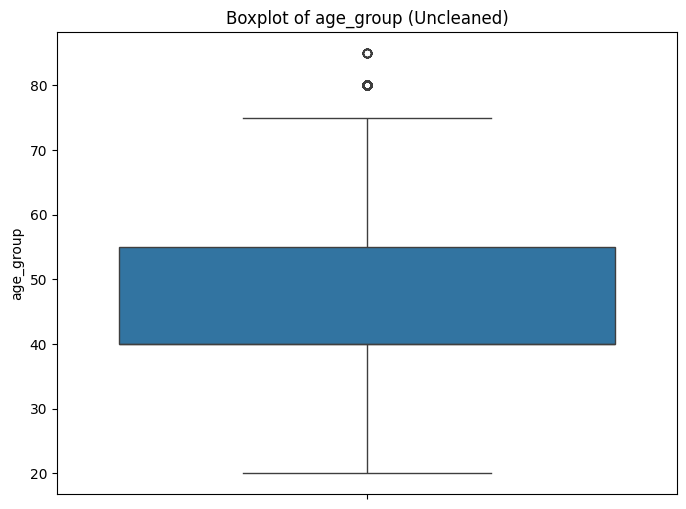

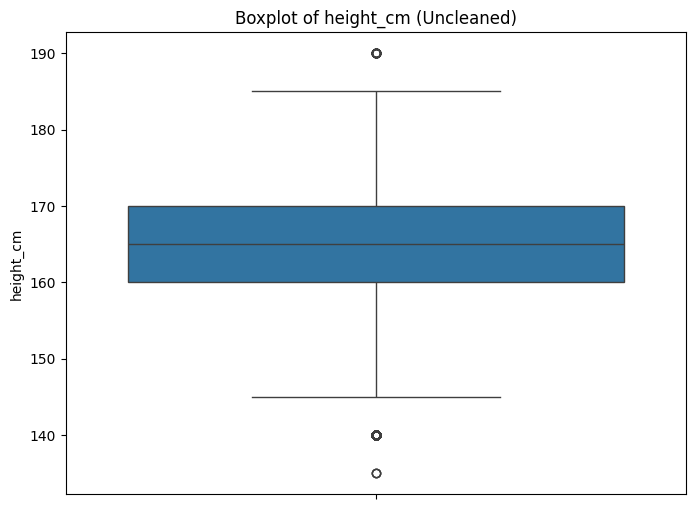

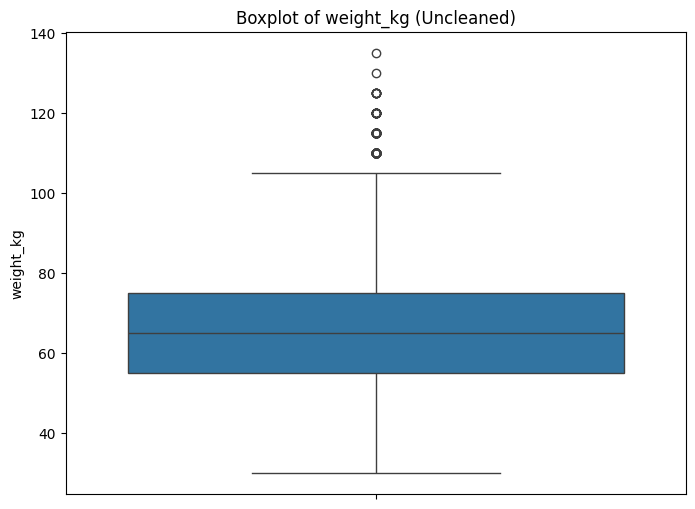

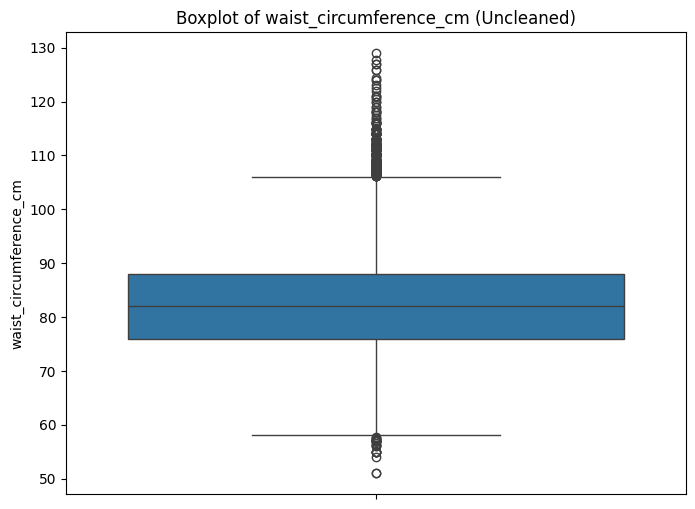

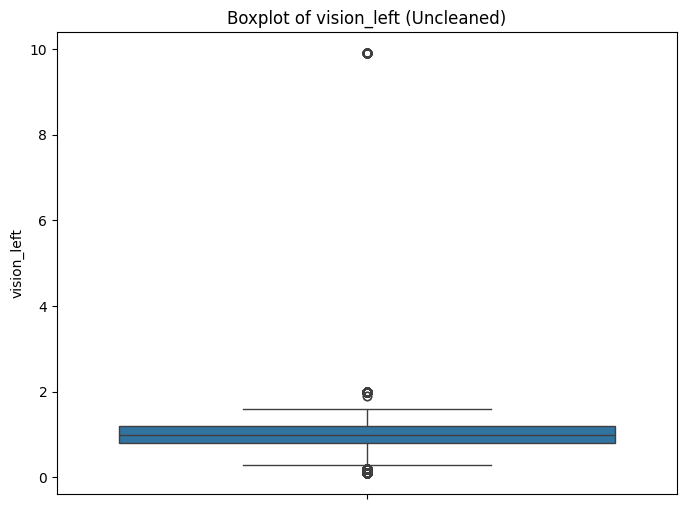

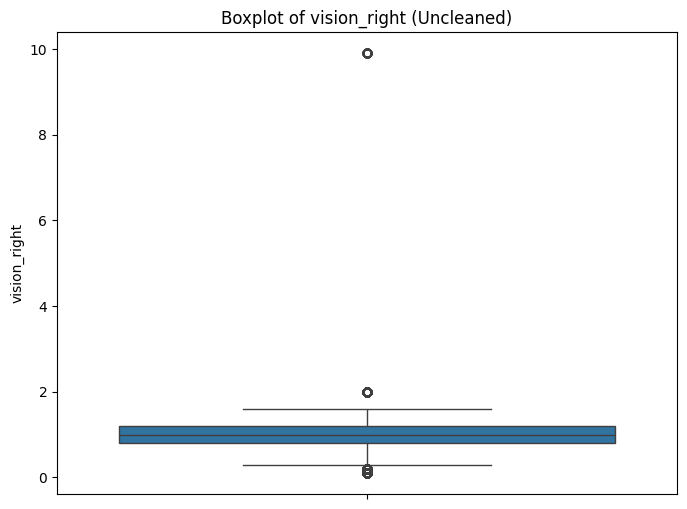

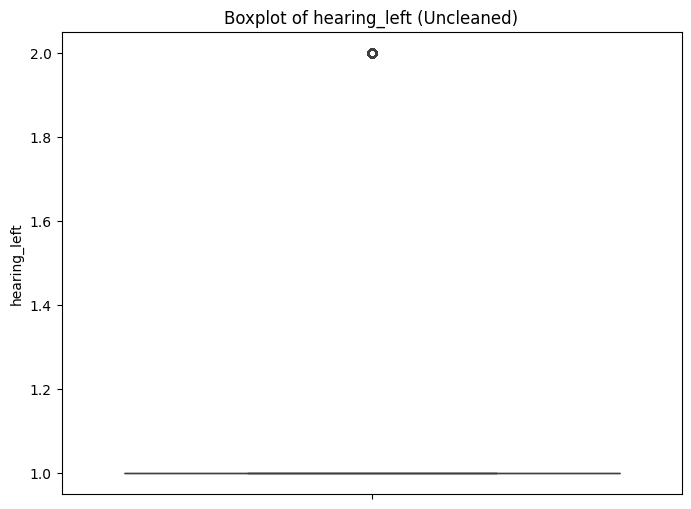

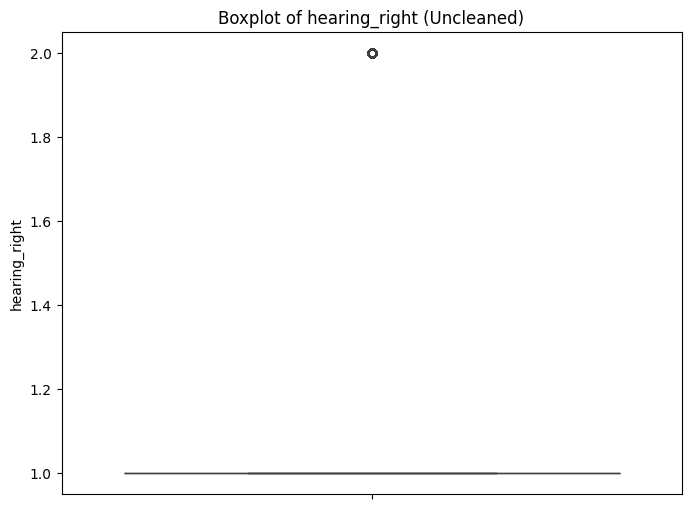

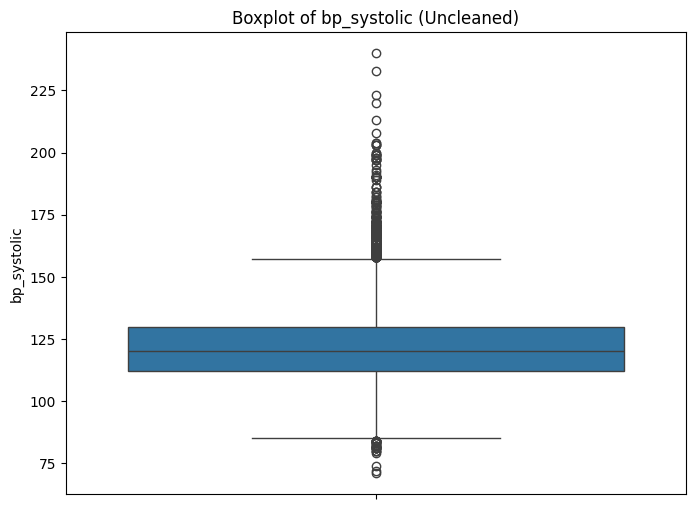

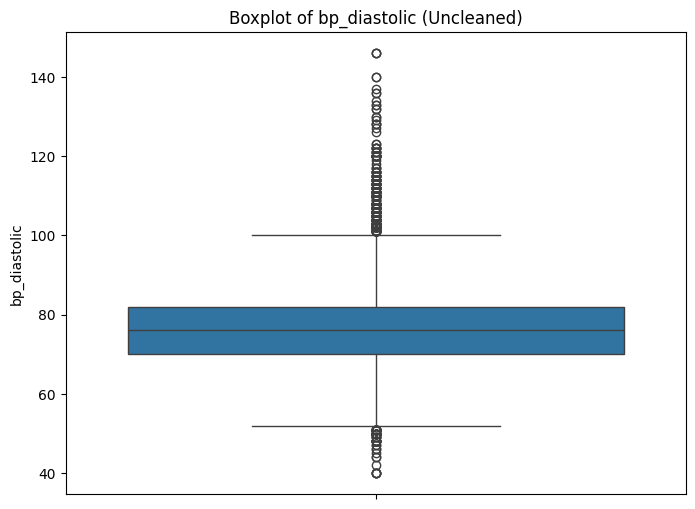

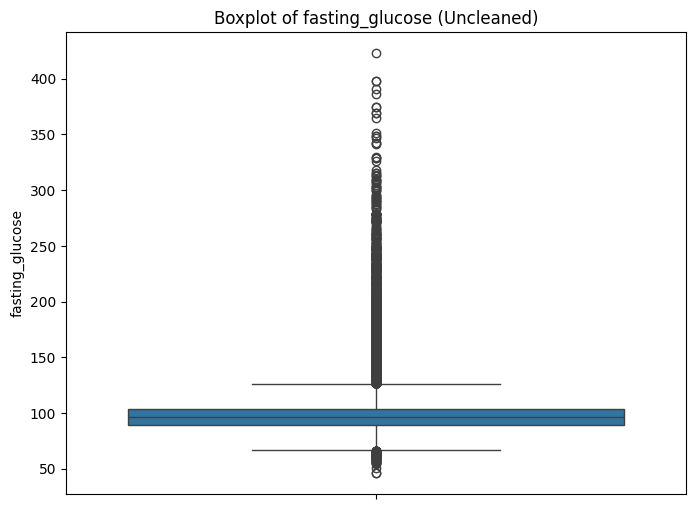

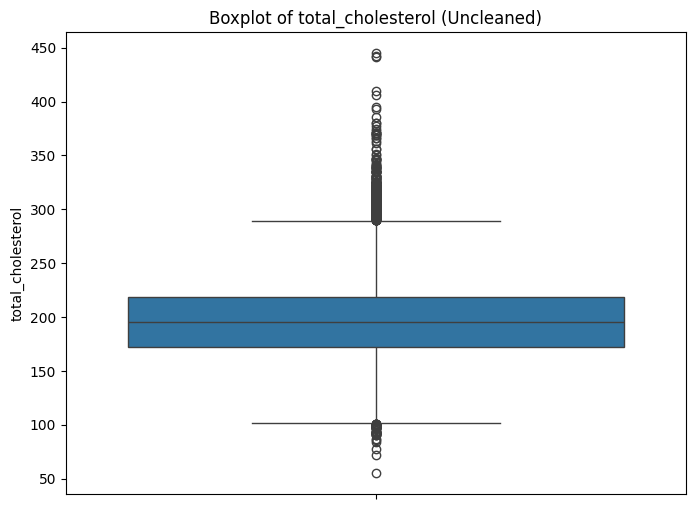

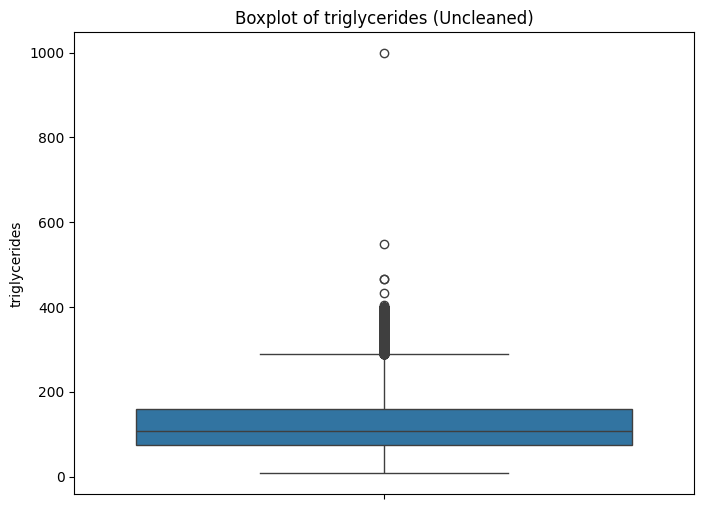

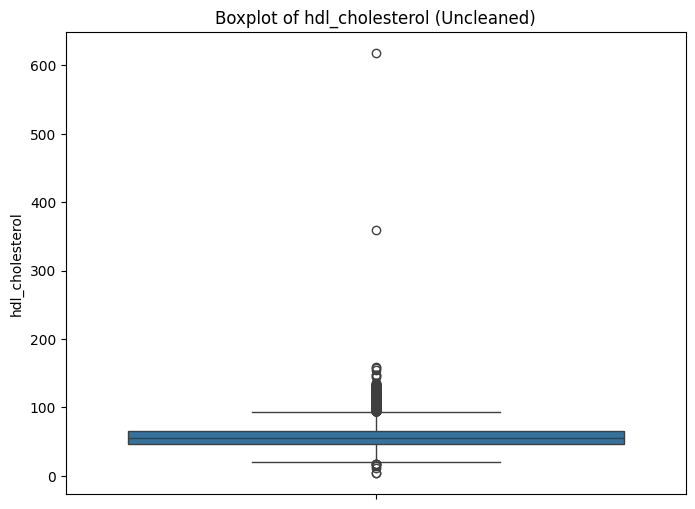

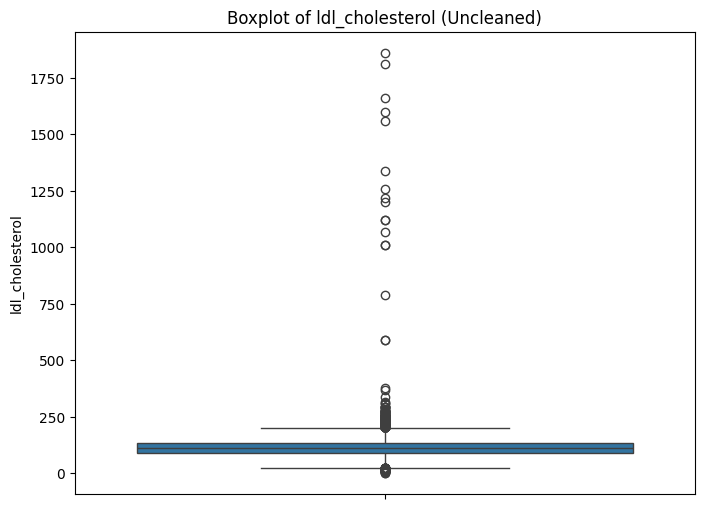

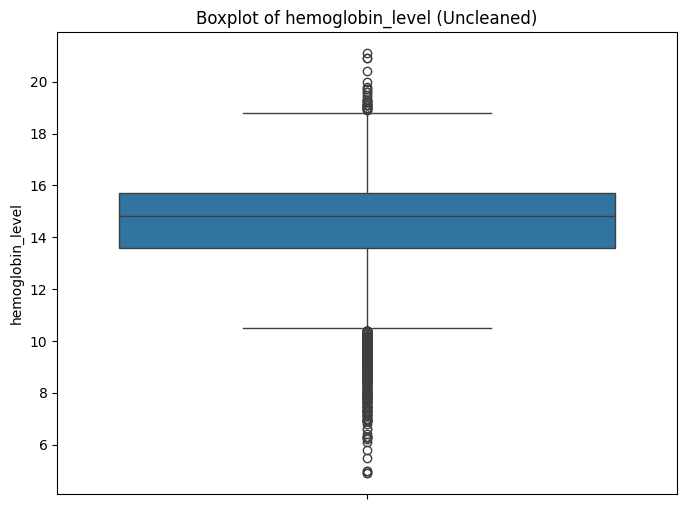

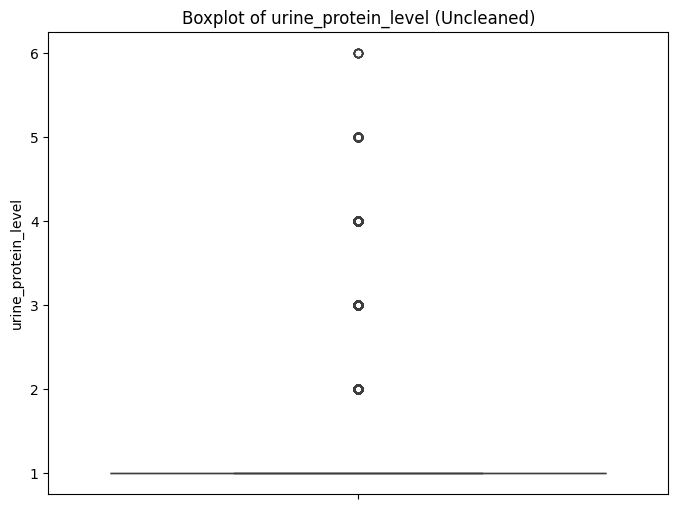

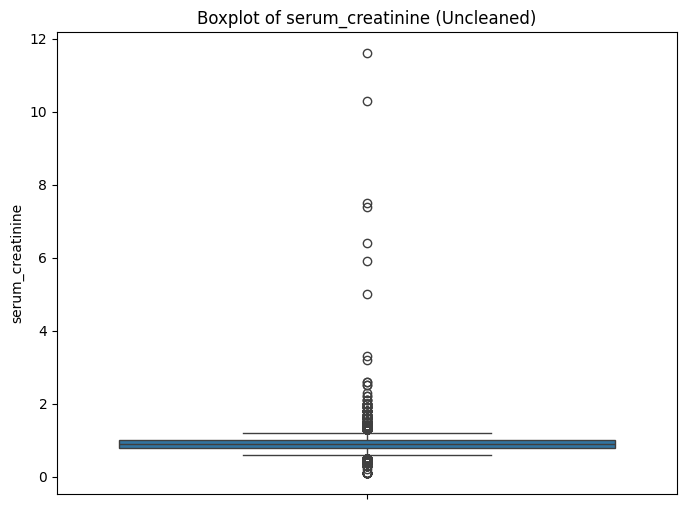

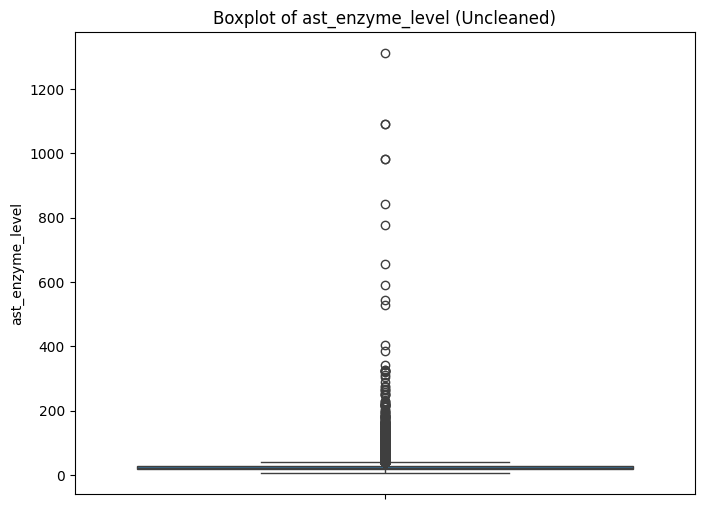

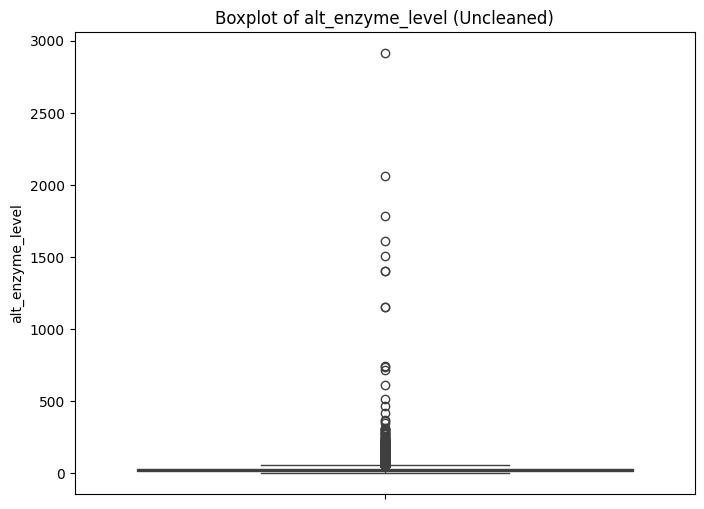

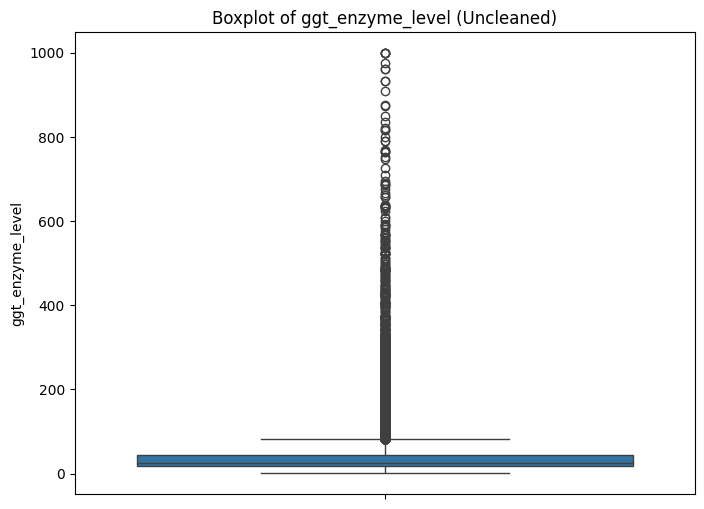

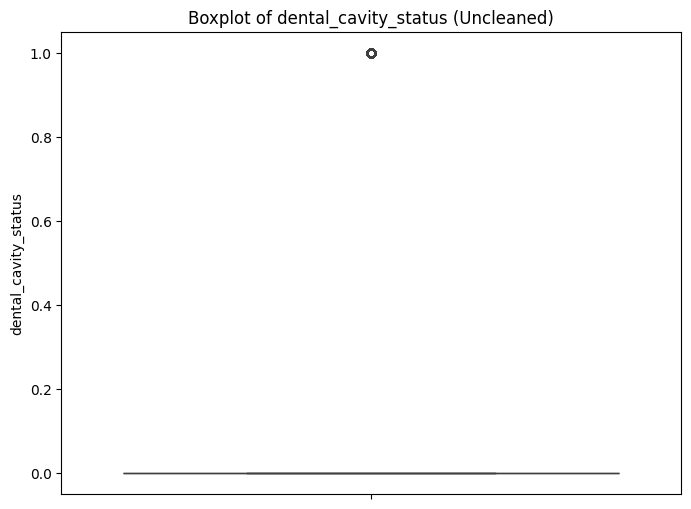

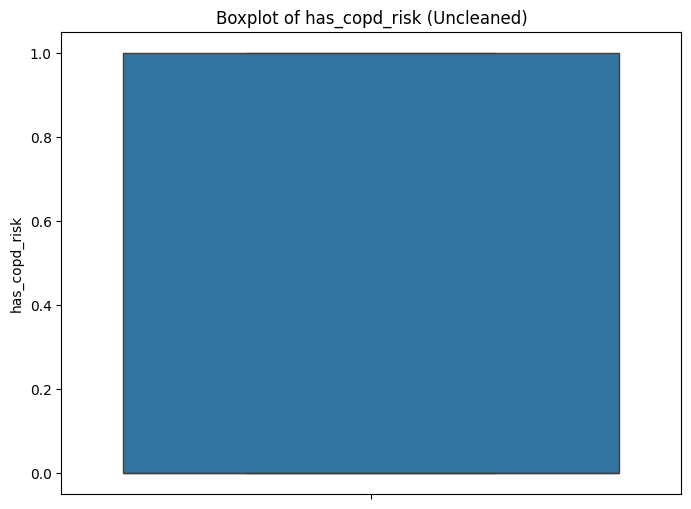


===== CORRELATION HEATMAP (CLEANED DATA) ====


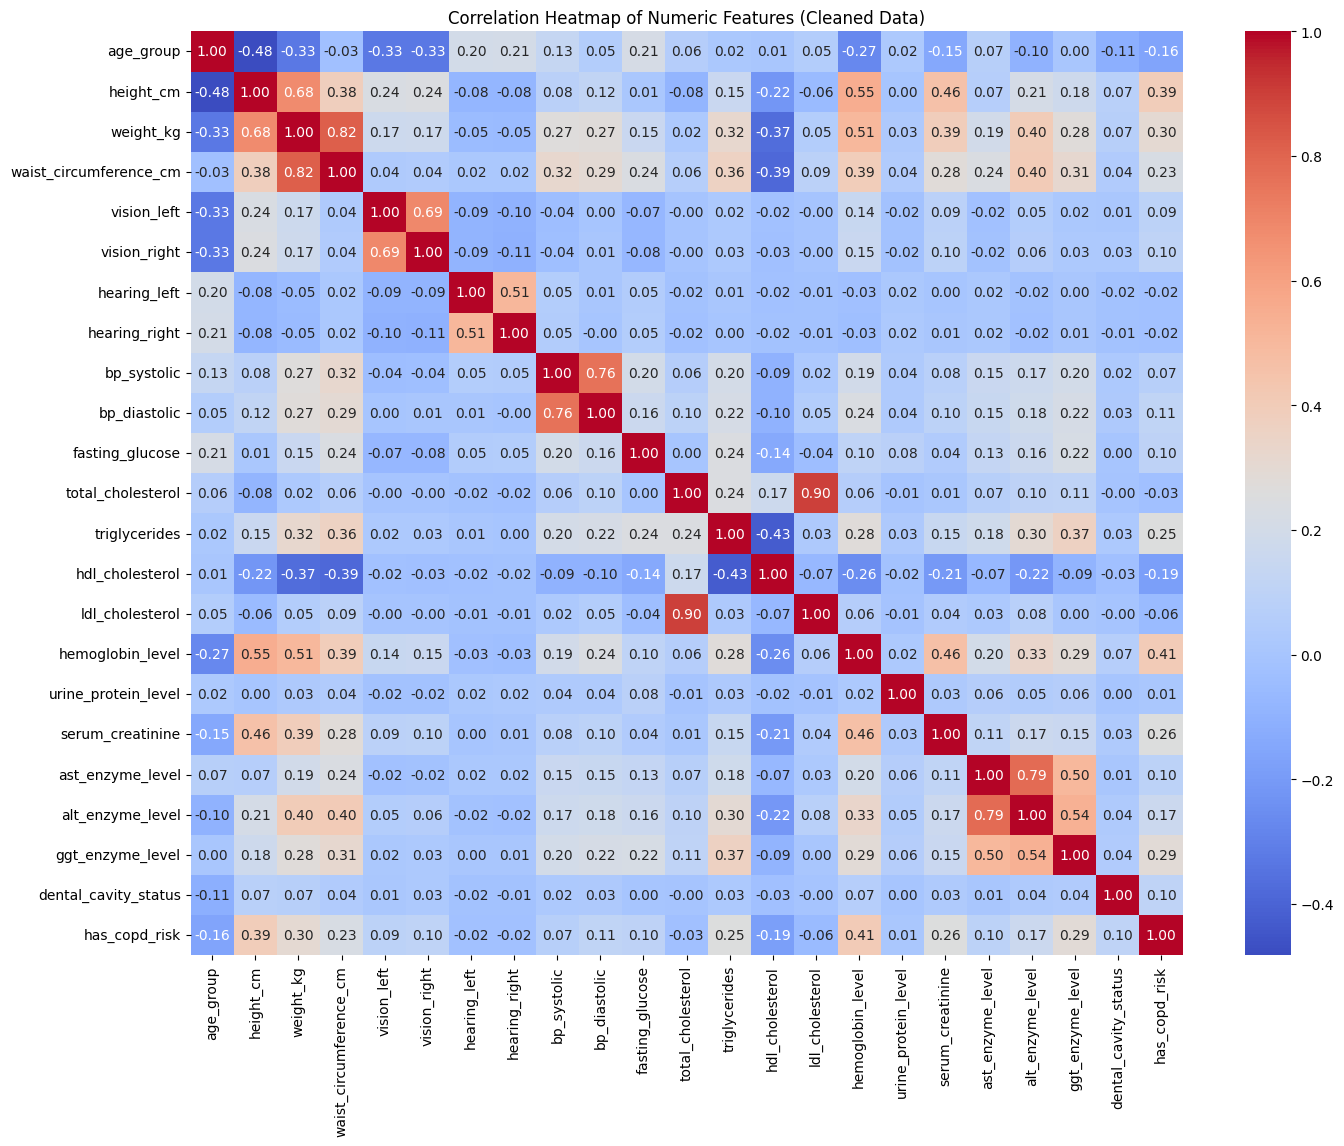

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize

# Load data
train = pd.read_csv("train.csv")

# Outlier removal (Winsorization)
df_clean = train.copy()
numeric_cols_for_winsorize = df_clean.select_dtypes(include=["float64", "int64"]).columns
numeric_cols_for_winsorize = [c for c in numeric_cols_for_winsorize if c not in ["patient_id"]]
for col in numeric_cols_for_winsorize:
    df_clean[col] = winsorize(df_clean[col], limits=[0.01, 0.01])

# Define numeric columns for plotting
numeric_cols_raw_cleaned = df_clean.select_dtypes(include=["float64", "int64"]).columns.tolist()
numeric_cols_raw_cleaned = [c for c in numeric_cols_raw_cleaned if c not in ["patient_id"]]

numeric_cols_raw_uncleaned = train.select_dtypes(include=["float64", "int64"]).columns.tolist()
numeric_cols_raw_uncleaned = [c for c in numeric_cols_raw_uncleaned if c not in ["patient_id"]]

print("\n===== BOXPLOTS (UNCLEANED NUMERIC COLUMNS) ====")
for col in numeric_cols_raw_uncleaned:
    plt.figure(figsize=(8, 6))
    sns.boxplot(y=train[col]) # Changed to 'train' for uncleaned data
    plt.title(f'Boxplot of {col} (Uncleaned)')
    plt.ylabel(col)
    plt.show()


print("\n===== CORRELATION HEATMAP (CLEANED DATA) ====")
plt.figure(figsize=(16, 12))
sns.heatmap(df_clean[numeric_cols_raw_cleaned].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numeric Features (Cleaned Data)')
plt.show()

In [4]:
# ============================================================
# PREPROCESSING (AFTER OUTLIER REMOVAL)
# ============================================================
df = df_clean.copy()

# Identify categorical columns before encoding
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
cat_cols = [c for c in cat_cols if c != target]

# One-hot encode train
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Encode target Y/N → 1/0
if df[target].dtype == "object":
    df[target] = df[target].map({"Y": 1, "N": 0})

# Prepare X, y
X = df.drop(columns=[target])
y = df[target].astype(int)

# Fill missing numeric values
X = X.fillna(X.mean())

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [5]:
# ============================================================
# TRAINING FUNCTION
# ============================================================
def train_models(test_size, n_components=None):

    X_train, X_val, y_train, y_val = train_test_split(
        X_scaled, y,
        test_size=test_size,
        random_state=42,
        stratify=y
    )

    print(f"\n======== Test Size = {test_size} ========")

    # PCA
    pca = PCA(n_components=n_components or 0.95, random_state=42)
    X_train_pca = pca.fit_transform(X_train)
    X_val_pca = pca.transform(X_val)

    print(f"PCA reduced {X_train.shape[1]} → {X_train_pca.shape[1]} features")

    # SMOTE (MLP only)
    sm = SMOTE(random_state=42)
    X_train_bal, y_train_bal = sm.fit_resample(X_train_pca, y_train)

    # ---------------- MLP ----------------
    mlp = MLPClassifier(
        hidden_layer_sizes=(32, 16),
        activation="relu",
        solver="adam",
        learning_rate_init=0.001,
        alpha=0.0005,
        batch_size=64,
        early_stopping=True,
        max_iter=400,
        n_iter_no_change=15,
        random_state=42
    )
    mlp.fit(X_train_bal, y_train_bal)
    mlp_acc = accuracy_score(y_val, mlp.predict(X_val_pca))

    # ---------------- LogReg ----------------
    logreg = LogisticRegression(max_iter=500, class_weight="balanced")
    logreg.fit(X_train_pca, y_train)
    logreg_acc = accuracy_score(y_val, logreg.predict(X_val_pca))

    # ---------------- Bayes ----------------
    bayes = GaussianNB()
    bayes.fit(X_train_pca, y_train)
    bayes_acc = accuracy_score(y_val, bayes.predict(X_val_pca))

    # ---------------- SVM GridSearch ----------------
    svm_param_grid = {
        "C": [0.3, 1, 3, 10],
        "gamma": ["scale", "auto", 1e-4, 3e-4, 1e-3],
        "kernel": ["rbf"]
    }

    svm = SVC(class_weight="balanced", random_state=42)

    svm_cv = GridSearchCV(
        svm,
        svm_param_grid,
        scoring="accuracy",
        cv=3,
        n_jobs=-1,
        verbose=1
    )
    svm_cv.fit(X_train_pca, y_train)
    svm_best = svm_cv.best_estimator_

    svm_acc = accuracy_score(y_val, svm_best.predict(X_val_pca))

    print(f"MLP Acc     = {mlp_acc:.4f}")
    print(f"LogReg Acc  = {logreg_acc:.4f}")
    print(f"Bayes Acc   = {bayes_acc:.4f}")
    print(f"SVM Acc     = {svm_acc:.4f}")
    print(f"Best SVM Params: {svm_cv.best_params_}")

    return mlp, logreg, bayes, svm_best, pca

In [6]:
# ============================================================
# TRAIN MODELS
# ============================================================
mlp_02, logreg_02, bayes_02, svm_02, pca_02 = train_models(0.2)
mlp_08, logreg_08, bayes_08, svm_08, pca_08 = train_models(0.8)


======== Test Size = 0.2 ========
PCA reduced 25 → 19 features
Fitting 3 folds for each of 20 candidates, totalling 60 fits
MLP Acc     = 0.7450
LogReg Acc  = 0.7298
Bayes Acc   = 0.7155
SVM Acc     = 0.7450
Best SVM Params: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}

======== Test Size = 0.8 ========
PCA reduced 25 → 19 features
Fitting 3 folds for each of 20 candidates, totalling 60 fits
MLP Acc     = 0.7446
LogReg Acc  = 0.7296
Bayes Acc   = 0.7120
SVM Acc     = 0.7362
Best SVM Params: {'C': 3, 'gamma': 'scale', 'kernel': 'rbf'}


In [7]:
# ============================================================
# PREPROCESS TEST SET (MATCH TRAIN COLUMNS)
# ============================================================
test_df = test.copy()
test_df = pd.get_dummies(test_df, columns=cat_cols, drop_first=True)

# Fix column mismatch (reindex)
test_df = test_df.reindex(columns=X.columns, fill_value=0)
test_scaled = scaler.transform(test_df)

In [8]:
# ============================================================
# APPLY PCA TO TEST SET
# ============================================================
test_pca_02 = pca_02.transform(test_scaled)
test_pca_08 = pca_08.transform(test_scaled)

In [9]:
# ============================================================
# SAVE RESULTS
# ============================================================
def save_output(filename, labels):
    pd.DataFrame({
        "patient_id": test["patient_id"],
        "has_copd_risk": labels
    }).to_csv(filename, index=False)

save_output("copd_predictions_mlp_02.csv", mlp_02.predict(test_pca_02))
save_output("copd_predictions_logreg_02.csv", logreg_02.predict(test_pca_02))
save_output("copd_predictions_bayes_02.csv", bayes_02.predict(test_pca_02))
save_output("copd_predictions_svm_02.csv", svm_02.predict(test_pca_02))

save_output("copd_predictions_mlp_08.csv", mlp_08.predict(test_pca_08))
save_output("copd_predictions_logreg_08.csv", logreg_08.predict(test_pca_08))
save_output("copd_predictions_bayes_08.csv", bayes_08.predict(test_pca_08))
save_output("copd_predictions_svm_08.csv", svm_08.predict(test_pca_08))

print("\nAll predictions saved.")


All predictions saved.


In [10]:
len(train)

44553

In [11]:
len(df_clean)

44553